In [262]:
!pip install folium
!pip install plotly
!pip install kaleido

In [263]:
# declaration of required functions, libs, enums, constants, etc..
from pandas import DataFrame
from typing import List
from io import StringIO
from enum import Enum
from pandas.api.types import CategoricalDtype
import pandas as pd
import seaborn as sns
import requests
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import folium
from folium.plugins import HeatMap
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode,  iplot
import plotly.io as pio

pio.renderers.default = 'notebook'
init_notebook_mode(connected=True)

headers = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.12; rv:55.0) Gecko/20100101 Firefox/55.0',
}
url_base = 'https://www.mibici.net/site/assets/files/'
datasets_to_download = [
    '3292/datos_abiertos_2021_05.csv',
    '21842/datos_abiertos_2022_05.csv',
    '46759/datos_abiertos_2023_05.csv',
    '4572/datos_abiertos_2021_06.csv',
    '23473/datos_abiertos_2022_06.csv',
    '48116/datos_abiertos_2023_06.csv',
    '5728/datos_abiertos_2021_07.csv',
    '25235/datos_abiertos_2022_07.csv',
    '49448/datos_abiertos_2023_07.csv'
]
age_bins = pd.IntervalIndex.from_tuples([(i, i+10) for i in range(0, 100,10)])

hour_day_bins = pd.IntervalIndex.from_tuples([(i, i+1) for i in range(0, 23,1)])
    
class DataSethMonth(Enum):
    MAY = 0
    JUNE = 1
    JULY = 2
    
def rename_columns(df: DataFrame) -> DataFrame:
    temp_df = df.copy()
    existing_columns = ['Viaje_Id', 'Usuario_Id', 'Genero', 'Año_de_nacimiento', 'Inicio_del_viaje', 'Fin_del_viaje', 'Origen_Id', 'Destino_Id']
    new_columns = ['trip_id', 'user_id', 'gender', 'birthday', 'start_trip', 'end_trip', 'origin_id', 'destination_id']
    
    for idx, new_column in enumerate(new_columns):
        temp_df[new_column] = temp_df[existing_columns[idx]]
        del temp_df[existing_columns[idx]]
    
    return temp_df

def add_new_columns(df: DataFrame) -> DataFrame:
    from datetime import datetime, date
    
    temp_df = df.copy()
    now = datetime.now()
    current_year = now.year

    # calculate user's age and add it to dataframe
    temp_df["age"] = current_year - temp_df["birthday"]
    temp_df['age_range'] = pd.cut(temp_df['age'], bins=age_bins)
    
    # calculate trip duration
    temp_df['start_trip_date'] = pd.to_datetime(temp_df['start_trip'])
    temp_df['start_trip_hour'] = temp_df.start_trip_date.dt.hour
    temp_df['start_trip_hour_range'] = pd.cut(temp_df['start_trip_hour'], bins=hour_day_bins)
    temp_df['start_trip_day_name'] = temp_df.start_trip_date.dt.day_name()
    temp_df['start_trip_day_number'] = temp_df.start_trip_date.dt.dayofweek
    temp_df['end_strip_date'] =  pd.to_datetime(temp_df['end_trip'])
    
    temp_df["trip_duration_hours"] = (temp_df["end_strip_date"] - temp_df['start_trip_date']) / pd.Timedelta(1, 'h')
    temp_df["trip_duration_hours"] = temp_df["trip_duration_hours"].round(2)
    temp_df["trip_duration_minutes"] = (temp_df["end_strip_date"] - temp_df['start_trip_date']) / pd.Timedelta(1, 'm')
    temp_df["year"] = temp_df.start_trip_date.dt.year
    
    del temp_df['start_trip_date']
    del temp_df['end_strip_date']
    
    return temp_df

def reorder_columns(df: DataFrame) -> DataFrame:
    temp_df = df.copy()
    columns_order = [
        'trip_id', 
        'user_id', 
        'gender', 
        'birthday', 
        'age',
        'age_range',
        'start_trip', 
        'start_trip_hour',
        'start_trip_hour_range',
        'start_trip_day_name',
        'start_trip_day_number',
        'end_trip',
        'trip_duration_minutes',
        'trip_duration_hours',
        'year',
        'origin_id',
        'origin_name',
        'origin_obcn',
        'origin_location',
        'origin_latitude',
        'origin_longitude',
        'origin_status',
        'destination_id',
        'destination_name',
        'destination_obcn',
        'destination_location',
        'destination_latitude',
        'destination_longitude',
        'destination_status'
    ]
    
    return temp_df.reindex(columns=columns_order)

def add_origin_destination_nomenclature(df: DataFrame, nomenclature: DataFrame):
    temp_df = df.copy()
    
    for left_on in ['origin', 'destination']:    
        temp_df = temp_df.merge(nomenclature, left_on=f"{left_on}_id", right_on='id', suffixes=(None, f"_{left_on}"))

        temp_df[f"{left_on}_name"] = temp_df['name']
        temp_df[f"{left_on}_obcn"] = temp_df['obcn']
        temp_df[f"{left_on}_location"] = temp_df['location']
        temp_df[f"{left_on}_latitude"] = temp_df['latitude']
        temp_df[f"{left_on}_longitude"] = temp_df['longitude']
        temp_df[f"{left_on}_status"] = temp_df['status']


        del temp_df['id']
        del temp_df['name']
        del temp_df['obcn']
        del temp_df['location']
        del temp_df['latitude']
        del temp_df['longitude']
        del temp_df['status']

    return temp_df

def formatter(x, pos):
    return str(round(x / 1e6, 1)) + " million"

In [218]:
raw_dataframes: List[DataFrame] = []

# making requests to get raw datasets from MiBici endpoints
for dataset_url in datasets_to_download:
    response = requests.get(f"{url_base}{dataset_url}", headers=headers)
    data = StringIO(response.text)
    temp_df = pd.read_csv(data)
    raw_dataframes.append(temp_df)

In [219]:
# getting station's datasets
stations_url = '1118/nomenclatura_2023_08-1.csv'
response = requests.get(f"{url_base}{stations_url}", headers=headers)
print(response)
data = StringIO(response.text)
station_df = pd.read_csv(data)

<Response [200]>


In [233]:
# processing raw datasets
# fix for birthday column within all datasets
for raw_dataframe in raw_dataframes:
    if "A}äe_nacimiento" in raw_dataframe:
        raw_dataframe['Año_de_nacimiento'] = raw_dataframe['A}äe_nacimiento']
        del raw_dataframe['A}äe_nacimiento']

    if "AÃ±o_de_nacimiento" in raw_dataframe:
        raw_dataframe['Año_de_nacimiento'] = raw_dataframe['AÃ±o_de_nacimiento']
        del raw_dataframe['AÃ±o_de_nacimiento']
        
# joining dataframes
raw_mibici_df = pd.concat(raw_dataframes.copy())

# removing emtpy values
mibici_df = mibici_df.dropna()
# structuring and enriching data
mibici_df = rename_columns(raw_mibici_df)
mibici_df = add_new_columns(mibici_df)
mibici_df = reorder_columns(mibici_df)

# add origin-destination data
mibici_df = add_origin_destination_nomenclature(mibici_df, nomenclature=station_df)

# calculating upper and lower limit to avoid outliers for age
upper_limit_age = mibici_df['age'].mean() + 2* mibici_df['age'].std() # Right from the mean
lower_limit_age = mibici_df['age'].mean() - 2* mibici_df['age'].std() # Left from the 

# calculating upper and lower limit to avoid outliers for trip duration
upper_limit_trip_duration = mibici_df['trip_duration_hours'].mean() + 2* mibici_df['trip_duration_hours'].std() # Right from the mean
lower_limit_trip_duration = mibici_df['trip_duration_hours'].mean() - 2* mibici_df['trip_duration_hours'].std() # Left from the mean

# removing outliers
mibici_df = mibici_df[(mibici_df['age']>lower_limit_age) & (mibici_df['age']<upper_limit_age)].copy()
mibici_df = mibici_df[(mibici_df['trip_duration_hours']>lower_limit_trip_duration) & (mibici_df['trip_duration_hours']<upper_limit_trip_duration)].copy()

## Análisis de dataset de MiBici de Guadalajara, México

### Abstract

El siguiente dataset contiene información de los viajes del sistema de Bicicletas Públicas MiBici del Área Metropolitana de Guadalajara del mes de mayo del 2020 al 2023, el programa actúa como complemento o extensión a otros sitemas de transporte de la ciudad, el sistema actualmente cuenta con 3,200 bicicletas y 300 estaciones en los municipios de Guadalajara, Zapopan y Tlaquepaque.

Desde que la plataforma inicio se ha visto un incremento consistente en el número de usuarios de la plataforma, en cuanto a los usuarios que se han mantenido activos también es consistente el crecimiento. 

El análisis de los viajes, tanto su destino como origen, nos pueden dar varios indicadores de que estaciones son las más concurridas, o los destinos de mayor concurrencia de los viajes, esto nos puede dar una idea de en que horarios y hacia que zonas los usuarios se mueven en el día a día y con este análisis poder identificar en que estaciones se requiere mas bicis y mantenimiento al sistema de conexión.

El sistema de conexión de las estaciones han sido reportados diferentes fallos, pero principalmente fallos relacionados con el inicio/finalización de los viajes, hay diferentes factores que influyen en el fallo, desde el hardware de wifi en las estaciones y también la demanda en horas picas en dichas estaciones.

Estas fallas en el sistema de conexión nos llevan a tener viajes sin finalización, o viajes finalizados despues de varios dias de su inicio, así como otras inconsistencias en los datos recabados por el sistema, además de ofrecer una mala experiencia para el usuario.

En el dataset encontramos información acerca de los usuarios y sus viajes, así como datos extras relacioandos con las estaciones de origen y destino de los viajes, así como su ubicación y a la zona a la que pertenecen.

### Preguntas e Hipótesis

Algunas preguntas de interes que han surgido apartir del análisis del dataset son:

* ¿Podríamos identificar los días y horarios con mayor afluencia de usuarios iniciando/finalizando viajes? Esto nos podría dar un mejor entendimiento de los horarios con mayor carga para el sistema de conexión de las estaciones, así como ver en que horario programar los mantenimientos preventivos de cada estación
* ¿Qué factores están impulsando la adopción del uso de MiBici entre hombres y mujeres?
* ¿Podemos pronosticar que estaciones origen/destino son y serán las más concurridas en los próximos meses?, esto nos podría ayudar a dar mantenimiento preventivo a los sitemas de conexión en dichas estaciones
* ¿Es la edad y género un factor en el tiempo de duración de los viajes de los usuarios?
* ¿Es el género un factor sobre la afluencia de usuarios en horarios nocturnos?, la inseguridad en general y el acoso/inseguridad en específico hacia el género femenino podrían estar afectando la adopción del uso de MiBici

## Definición de objetivo

¿Cómo podemos optimizar el mantenimiento para el sistema de conexión de las estaciones sin afectar la disponibilidad del servicio?
¿Cómo podemos disminuir la brecha de la adopción del servicio entre los usuarios de género masculino y femenino?

## Contexto comercial

El área metropolitana de guadalajara brinda servicio a miles de usuarios quiénes usan la bicicleta como principal medio de transporte en su día a día, el servicio a experimentado una creciente demanda desde que fue implementado en 2014 gracias a la suma de esfuerzos de colectivos ciclistas y dependencias gubernamentales que han promovido el uso de la bicicleta en la metrópoli. Actualmente el programa cuenta con 3200 bicicletas y 300 estaciones en los municipios de Guadalajara, Zapopan y Tlaquepaque.

La Agencia Metropolitana de Servicios de Infraestructura para la Movilidad (AMIM), es el organimos público descentralizado intermunicipial que se encarga de supervisar la red de semáforos, radares de velocidad y el sistema de bicicleta pública "MiBici", PIMA es el programa de infraestructura para la Movilidad Activa que concentra la operación de "MiBici".

Por otra parte las mejores al sistema continuán, aun así, se han recibido reporte por parte de los usuarios que han tenido problemas con servicio, al iniciar un viaje, finalizar el viaje, etc.. Además de que se ve afectada la disponibilidad de las bicicletas cuando se les da mantenimiento.

### Días mas concurridos por los usuarios de MiBici

A continuación haremos un análisis de los días mas concurridos por los usuarios de MiBici en los últimos 3 años

Text(0, 0.5, 'Viajes por día')

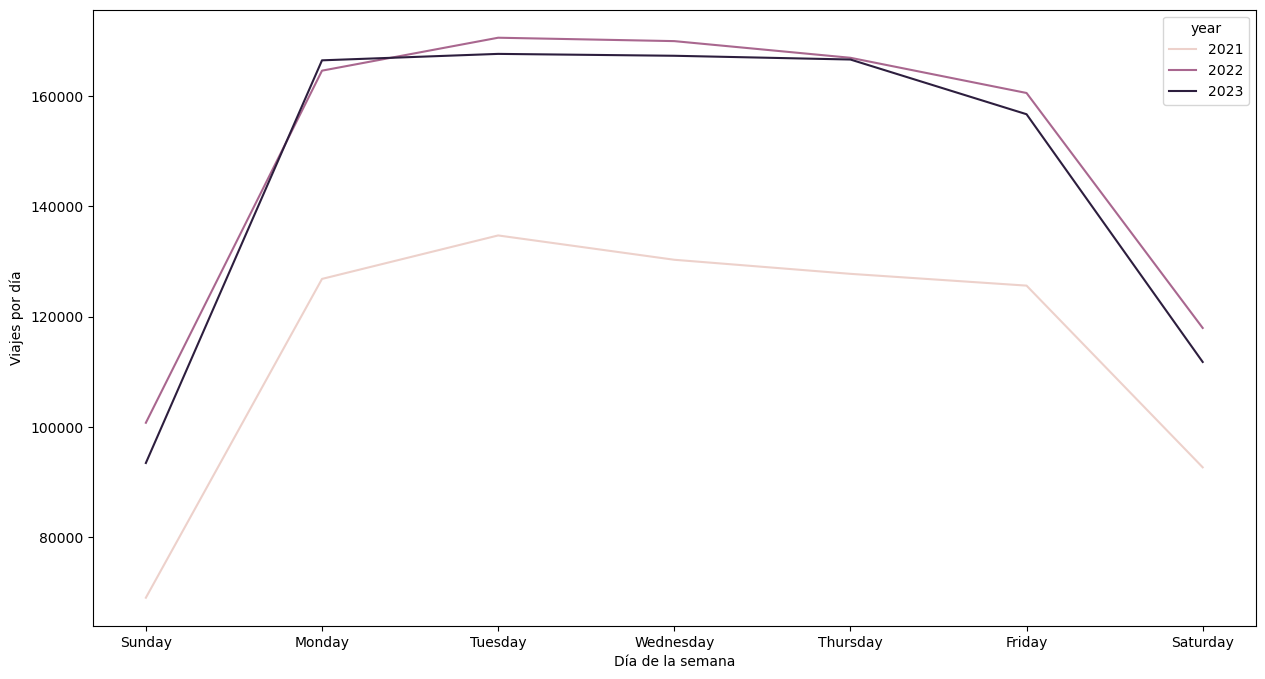

In [221]:
# visualization of trips by day
trips_by_year_day = mibici_df.groupby(by=['year', 'start_trip_day_name'], as_index=False).size()

days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
day_name = CategoricalDtype(categories=days, ordered=True)
trips_by_year_day['day'] = trips_by_year_day['start_trip_day_name'].astype(day_name)

# creating graph
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.lineplot(data=trips_by_year_day, x='day', y="size", hue="year", ax=ax)
ax.set_xlabel('Día de la semana')
ax.set_ylabel('Viajes por día')

### Distribución de viajes en un lapso de 24 hrs

En el siguiente gráfico podemos observar en que horarios se realizan la mayoría de viajes en bicicleta por parte de los usuarios, así mismo separados por día de la semana, ya que es diferente dependiendo del día de la semana

In [265]:
mibici_df_start_trip_by_hour = mibici_df.groupby(["start_trip_hour", "start_trip_day_name"])["start_trip_hour"].count().reset_index(name="count").reset_index(drop=True)

fig = px.line(
    mibici_df_start_trip_by_hour, 
    x="start_trip_hour", 
    y="count", 
    line_group="start_trip_day_name", 
    color="start_trip_day_name", 
    title='Cantidad de viajes por hora del día',
    labels={
         "start_trip_hour": "Hora de inicio del viaje (formato 24 hrs)",
         "start_trip_day_name": "Día del viaje",
         "count": "Número de viajes"
     },
)
fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1
    )
)
# iplot(fig)
# fig.show() #interactive chart
pio.show(fig)

### Viajes de los usuarios por género y año 

A continuación haremos un análisis de como ha crecido el uso de MiBici en los últimos 2 años por género, como podemos observar la adopción del servicio entre el género masculino y femenino es visiblemente muy diferente, esto nos muestra que hay oportunidad de crecimiento y ganar más usuarios para MiBici

Text(0.5, 0, 'Año')

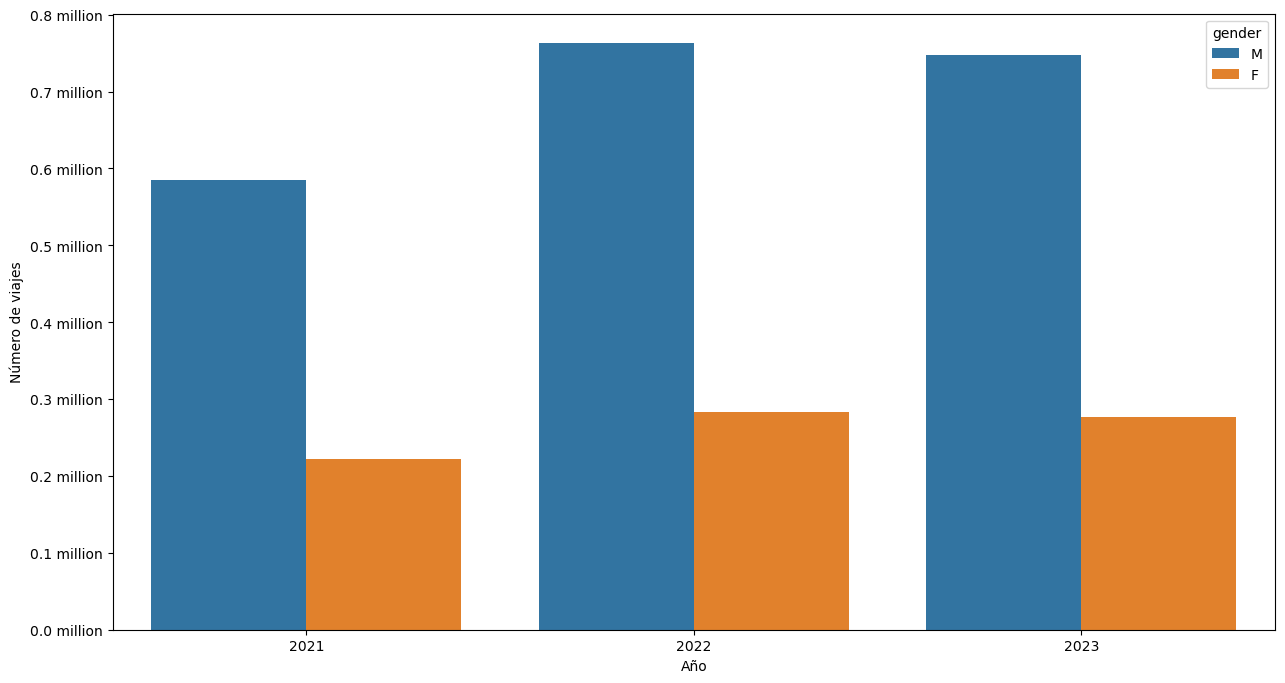

In [228]:
# count trips by year plot
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.countplot(data=mibici_df, x="year", ax=ax, hue='gender')
ax.yaxis.set_major_formatter(formatter)
ax.yaxis.set_minor_formatter(NullFormatter())

ax.set_ylabel("Número de viajes")
ax.set_xlabel("Año")

### Edad de los usuarios distribuidos por año y género

A continuación haremos un análisis de como ha crecido el uso de MiBici en los últimos 2 años por género, como podemos observar la adopción del servicio entre el género masculino y femenino es visiblemente muy diferente, esto nos muestra que hay oportunidad de crecimiento y ganar más usuarios para MiBici

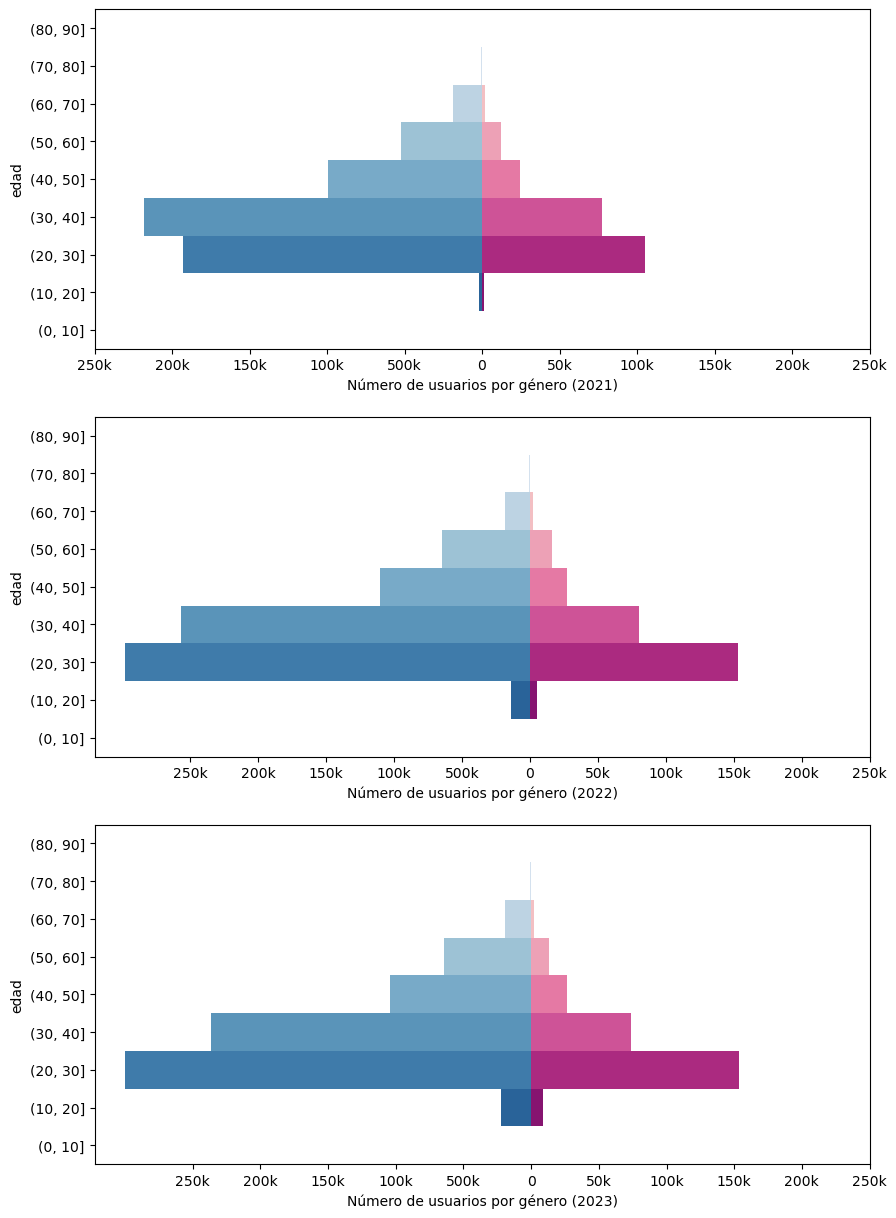

In [229]:
mibici_grouped_by_age_range = mibici_df.groupby(['year','gender','age_range' ])['age'].count().reset_index(name="count").reset_index(drop=True)
mibici_grouped_by_age_range['age_range'] = mibici_grouped_by_age_range.age_range.astype(str)
mibici_grouped_by_age_range.loc[mibici_grouped_by_age_range['gender'] == 'M', 'count'] = mibici_grouped_by_age_range['count']* -1

ages = ['(80, 90]','(70, 80]', '(60, 70]', '(50, 60]', '(40, 50]', '(30, 40]', '(20, 30]', '(10, 20]', '(0, 10]']
ticks = [-250000, -200000, -150000, -100000, -50000, 0, 50000, 100000, 150000, 200000, 250000]
labels = ['250k', '200k', '150k', '100k', '500k', '0', '50k', '100k', '150k', '200k', '250k']

data_by_gender = lambda gender: (mibici_grouped_by_age_range['gender'] == gender)
data_by_year = lambda year: (mibici_grouped_by_age_range['year'] == year)

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,15))
sns.barplot(x='count', y='age_range', ax=ax[0], data=mibici_grouped_by_age_range[data_by_gender('M') & data_by_year(2021)], order=ages, palette="Blues", width=1)
sns.barplot(x='count', y='age_range', ax=ax[0], data=mibici_grouped_by_age_range[data_by_gender('F') & data_by_year(2021)], order=ages, palette="RdPu", width=1)
ax[0].set_xlabel('Número de usuarios por género (2021)')
ax[0].set_ylabel('edad')
ax[0].set_xticks(ticks=ticks,labels=labels)

sns.barplot(x='count', y='age_range', ax=ax[1], data=mibici_grouped_by_age_range[data_by_gender('M') & data_by_year(2022)], order=ages, palette="Blues", width=1)
sns.barplot(x='count', y='age_range', ax=ax[1], data=mibici_grouped_by_age_range[data_by_gender('F') & data_by_year(2022)], order=ages, palette="RdPu", width=1)
ax[1].set_xlabel('Número de usuarios por género (2022)')
ax[1].set_ylabel('edad')
ax[1].set_xticks(ticks=ticks,labels=labels)

sns.barplot(x='count', y='age_range', ax=ax[2], data=mibici_grouped_by_age_range[data_by_gender('M') & data_by_year(2023)], order=ages, palette="Blues", width=1)
sns.barplot(x='count', y='age_range', ax=ax[2], data=mibici_grouped_by_age_range[data_by_gender('F') & data_by_year(2023)], order=ages, palette="RdPu", width=1)
ax[2].set_xlabel('Número de usuarios por género (2023)')
ax[2].set_ylabel('edad')
ax[2].set_xticks(ticks=ticks,labels=labels)

### Estaciones "origen", donde inician la mayoría de viajes en bicicleta

En el siguiente gráfico podemos observar cuales son las estaciones donde la mayoría de usuarios inicia su viaje, con este gráfico es visible las zonas con mayor demanda

In [230]:
mibici_origin_count = mibici_df.groupby(['origin_id','origin_obcn', 'origin_latitude', 'origin_longitude'])['origin_id'].count().reset_index(name="count").reset_index(drop=True)

origin_hmap = folium.Map(location=[20.677161, -103.359465], zoom_start=14, tiles="OpenStreetMap")
origin_heat_map = HeatMap( 
    list(zip(
        mibici_origin_count['origin_latitude'], 
        mibici_origin_count['origin_longitude'], 
        mibici_origin_count['count']
    )),
    min_opacity=0.8,
    radius=7, blur=6,
    max_zoom=20,
)
origin_hmap.add_child(origin_heat_map)

### Estaciones "destino", donde inician la mayoría de viajes en bicicleta

En el siguiente gráfico podemos observar cuales son las estaciones donde la mayoría de usuarios finaliza su viaje, con este gráfico es visible las zonas con mayor demanda.

In [231]:
mibici_destination_count = mibici_df.groupby(['destination_id','destination_obcn', 'destination_latitude', 'destination_longitude'])['destination_id'].count().reset_index(name="count").reset_index(drop=True)

destination_hmap = folium.Map(location=[20.677161, -103.359465], zoom_start=14, tiles="OpenStreetMap")
destination_heat_map = HeatMap( 
    list(zip(
        mibici_destination_count['destination_latitude'], 
        mibici_destination_count['destination_longitude'], 
        mibici_destination_count['count']
    )),
    min_opacity=0.8,
    radius=7, blur=6,
    max_zoom=20,
)
destination_hmap.add_child(destination_heat_map)